In [1]:
# Import modules
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

# Open the data from the last tutorial
ast_2020_jx1_df = pd.read_csv('../part17/2020_JX1_data.csv', sep=';')

In [2]:
# Convert to radians
ast_2020_jx1_df.loc[:, 'ECLIP_LONG_RAD'] = \
    np.radians(ast_2020_jx1_df['ECLIP_LONG_DEG'])

ast_2020_jx1_df.loc[:, 'ECLIP_LAT_RAD'] = \
    np.radians(ast_2020_jx1_df['ECLIP_LAT_DEG'])

In [3]:
# The KDE algorithm in scikit learn does not allow one to set different
# bandwidths for different dimensions / axes. Using Scott's rule of thumb we
# could simply apply one bandwidth for all dimensions, right?
#
# To check this, let's determine the standard deviation of the longitude and
# latitude values, respectively.
print('Standard deviation of the longitude in radians: '
      f'{np.std(ast_2020_jx1_df["ECLIP_LONG_RAD"])}')
print('Standard deviation of the latitude in radians: '
      f'{np.std(ast_2020_jx1_df["ECLIP_LAT_RAD"])}')
print('\n')

Standard deviation of the longitude in radians: 9.018716284604213e-05
Standard deviation of the latitude in radians: 6.602797374663462e-05




In [4]:
# We need a multivariate alternative to scikit learn...
#
# https://www.statsmodels.org/stable/generated/
#     statsmodels.nonparametric.kernel_density.KDEMultivariate.html
import statsmodels.nonparametric.kernel_density as statmKDE

# Get the longitude and latitude values of the asteroid
AST_LONG_LAT = ast_2020_jx1_df[['ECLIP_LONG_RAD', 'ECLIP_LAT_RAD']].values

# Compute now the 2D multivariate KDE
DENS_MODEL = statmKDE.KDEMultivariate(data=AST_LONG_LAT, \
                                      var_type='cc', \
                                      bw='normal_reference')

In [5]:
# Let's print the bandwidth results
print(f'Bandwidth longitude in radians (normal ref.): {DENS_MODEL.bw[0]}')
print(f'Bandwidth latitude in radians (normal ref.): {DENS_MODEL.bw[1]}')
print('\n')

Bandwidth longitude in radians (normal ref.): 3.0230866132012703e-05
Bandwidth latitude in radians (normal ref.): 2.2132671350467688e-05




In [6]:
# Do the results from other bw-determining methods differ?
DENS_MODEL_TEMP = statmKDE.KDEMultivariate(data=AST_LONG_LAT, \
                                           var_type='cc', \
                                           bw='cv_ml')

print(f'Bandwidth longitude in radians (cv_ml): {DENS_MODEL_TEMP.bw[0]}')
print(f'Bandwidth latitude in radians (cv_ml): {DENS_MODEL_TEMP.bw[1]}')
print('\n')

Bandwidth longitude in radians (cv_ml): 2.784302856547355e-05
Bandwidth latitude in radians (cv_ml): 2.5161408683213527e-05




In [7]:
# To obtain a probability density function (pdf) that is based on the model,
# we need to compute the pdf in a for-loop in 'latitude-slices'. The resulting
# 'pdf per latitude results' are stored in the following placeholder list
pdf_final = []

# Iterate through the latitude, from the minimum to maximum latitude values
# that are present in the data
for _lat in tqdm(np.linspace(ast_2020_jx1_df.ECLIP_LAT_RAD.min(), \
                             ast_2020_jx1_df.ECLIP_LAT_RAD.max(), \
                             100)):

    # Compute a temporary array that contains 1000 longitude values from the
    # long. min. to the long. max. value and a fixed latitude value from the
    # for-loop
    long_lat_array = np.linspace((ast_2020_jx1_df.ECLIP_LONG_RAD.min(), \
                                  _lat), \
                                 (ast_2020_jx1_df.ECLIP_LONG_RAD.max(), \
                                  _lat), \
                                 100)

    # Compute the corresponding pdf ...
    pdf = DENS_MODEL.pdf(long_lat_array)

    # ... and store it in the final list
    pdf_final.append(pdf)

# Convert the final list to a numpy array
pdf_final = np.array(pdf_final)

# Invert the result
pdf_final = pdf_final[::-1]

100%|██████████| 100/100 [00:00<00:00, 129.20it/s]


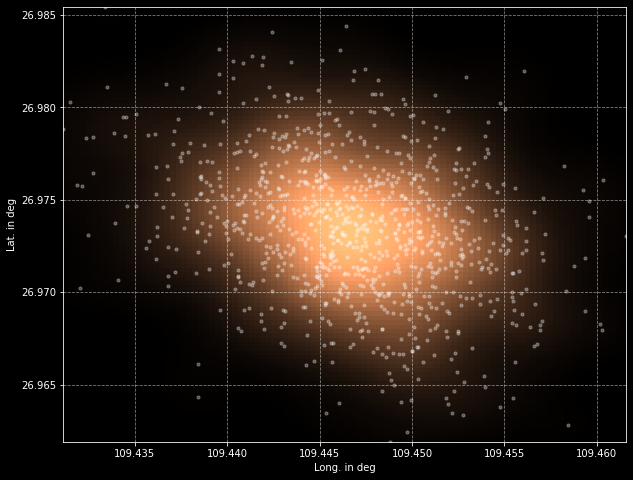

In [8]:
# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Plot the possible coordinates of the asteroid as a scatter plot
plt.scatter(x=ast_2020_jx1_df['ECLIP_LONG_DEG'], \
            y=ast_2020_jx1_df['ECLIP_LAT_DEG'], \
            c='white', alpha=0.3, s=10, marker='o')

# Create an overlay of the pdf. Use the extent argument to properly set the
# x and y axes
plt.imshow(pdf_final, \
           extent=[ast_2020_jx1_df.ECLIP_LONG_DEG.min(), \
                   ast_2020_jx1_df.ECLIP_LONG_DEG.max(), \
                   ast_2020_jx1_df.ECLIP_LAT_DEG.min(), \
                   ast_2020_jx1_df.ECLIP_LAT_DEG.max()], \
           cmap='copper')

# Set a grid
plt.grid(True, linestyle='dashed', alpha=0.5)

# Get the axes
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')

# Set long. / lat. labels
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')

# Save the figure
plt.savefig('2020_jx1_eclip_coords.png', dpi=300)